# Autoencoders

## Preliminaries

In [2]:
import numpy as np
import torch
import torch.nn as nn
import torchvision
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from tqdm import tqdm
import os
import random
#This part is only for dowloading in Colab
from six.moves import urllib
opener = urllib.request.build_opener()
opener.addheaders = [('User-agent', 'Mozilla/5.0')]
urllib.request.install_opener(opener)
#Set OS so that there is no error
os.environ['KMP_DUPLICATE_LIB_OK']='True'
#using GPU is you can
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [5]:
D = nn.Sequential(
            nn.Conv2d(1, 64, 3), nn.ReLU(),
            nn.Conv2d(64, 128, 3), nn.ReLU(),
            nn.Conv2d(128, 64, 3), nn.ReLU(),
            nn.Flatten(start_dim=1),
        )
s = torch.zeros((3, 1, 28, 28))
k = D(s)
pen = k.shape[-1]
pen


30976

# Dataset: MNIST

In [2]:
# You can change img_size to 14 if you want to use smaller (14x14) images.
img_size = 28
ds_full = torchvision.datasets.MNIST('./files/', train=True, download=True,
                            transform=torchvision.transforms.Compose([
                            torchvision.transforms.Resize((img_size,img_size)),
                            torchvision.transforms.ToTensor(),
                            ]))

In [3]:
ds = torch.utils.data.Subset(ds_full, range(1024))

In [4]:
def Draw(x):
    with torch.no_grad():
        plt.imshow(x.squeeze().detach().numpy(), cmap='gray');
        plt.axis('off');

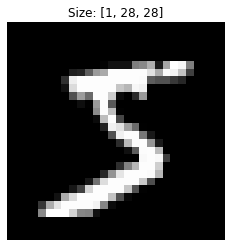

In [5]:
with torch.no_grad():
    x,t = ds.__getitem__(0)
    Draw(x)
    plt.title(f'Size: {list(x.size())}')
plt.show()

## Create some `DataLoader`s

In [6]:
# Batched, for training
batch_size_train = 10
train_dl = torch.utils.data.DataLoader(ds, batch_size=batch_size_train, shuffle=True)

In [7]:
# A single batch, for plotting
train_all = torch.utils.data.DataLoader(ds, batch_size=1024, shuffle=False)

# A. Complete the `ConvAE` class

In [8]:
class ConvAE(nn.Module):
    '''
     net = ConvAE(img_size=28, embedding_dim=3)
     
     Create a convolutional autoencoder for imput images of size (img_size x img_size),
     with an embedding (latent) layer of (embedding_dim) neurons.
     
     Inputs:
       img_size       size of input images, [1, img_size, img_size]
       embedding_dim  number of nodes in embedding (latent) layer
       
     Usage:
       net = ConvAE()
       y = net(x)
       h = net.encode(x)  # returns latent vectors
    '''
    def __init__(self, img_size=28, embedding_dim=3):
        #This is some basic parameter when building CNN
        self.img_size = img_size
        l1 = self.img_size // 2 #layer one's kernel size
        l2 = l1 // 2 #layer two's kernel size
        l3 = l2 // 2 #layer three's kernel size
        offset = l1 + l2 + l3 - 3 #the image size after three kernel
        self.embedding_dim = embedding_dim
        self.losses = []
        super().__init__()
        #===== YOUR CODE HERE =====
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, l1, padding=0), # 1 channel to 32 chennels
            nn.ReLU(), 
            nn.Conv2d(32, 64, l2, padding=0), # 32 channel to 64 chennels
            nn.ReLU(),
            nn.Conv2d(64, 128, l3, padding=0), # 64 channel to 128 chennels
            nn.ReLU(),
            nn.Flatten(start_dim=1), #Flat
            nn.Linear(128 * (self.img_size-offset)**2, self.embedding_dim),
        )
        
        self.decoder = nn.Sequential(
            nn.Linear(self.embedding_dim,128 * (self.img_size-offset)**2),
            nn.Unflatten(1, (128,self.img_size-offset,self.img_size-offset )), #unflat
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, l3, stride=1), #128 channel to 64 channel
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, l2, stride=1),#64 channel to 32 channel
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, l1, stride=1), #32 channel to 1 channel
            nn.Sigmoid()
        )
        
        
        
    def encode(self, x):
        #===== YOUR CODE HERE =====
        return self.encoder(x)  # use encoder
    
    
    def decode(self, x):
        #===== YOUR CODE HERE =====
        return self.decoder(x)  # use decoder
  

    def forward(self, x):
        #===== YOUR CODE HERE =====
        return self.decoder(self.encoder(x)) #first encode then decode

    
    def learn(self, dl, epochs=10, optimizer=None, loss_fcn=None):
        '''
         net.learn(dl, epochs=10, optimizer=None, loss_fcn=None)
         
         Train the network on the dataset delivered by the dataloader dl.
         
         Inputs:
          dl        DataLoader object
          epochs    number of epochs to train
          optimizer PyTorch optimizer function
          loss_fcn  PyTorch loss function
        '''
        if optimizer is None or loss_fcn is None:
            print('Need to specify an optimizer and loss function')
            return

        for epoch in tqdm(range(epochs)):
            total_loss = 0.
            count = 0.
            for x, t in dl:
                y = self(x)
                loss = loss_fcn(y, x)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                total_loss += loss.item()*len(t)
                count += 1.
            self.losses.append(total_loss/len(dl.dataset))
            #print(f'Epoch: {epoch}, loss: {total_loss/count}')
        plt.figure(figsize=(4,4))
        plt.plot(self.losses); plt.yscale('log');

# B. Create and train the network

100%|██████████| 500/500 [46:07<00:00,  5.53s/it]


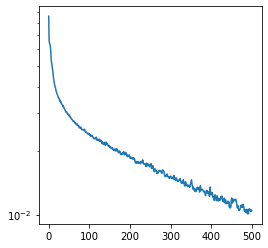

In [9]:
net = ConvAE(img_size=img_size, embedding_dim=3)
#use optimizer SGD, and learning rate to be 0.1, momentum rate to be 0.9
optimizer = torch.optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
#use loss function MSE and then 500 loop training
net.learn(train_dl, 500, optimizer, nn.MSELoss())

In [10]:
# Uncomment the following line if you want to save your network.
#torch.save(net.to('cpu'), 'my_ConvAE.pt')
# The corresponding code to reload the network is below.
#net = torch.load('my_ConvAE.pt')
# Remember to send it to the GPU, if you're using one.
#net.to(device)

# C. Plot the latent space

In [11]:
# Here are 10 colours you can use. But feel free to use others, too.
colour_options = ['k', 'r', 'orange', 'tab:brown', 'y', 'g', 'teal', 'b', 'mediumpurple', 'gray']
#data is the result of encoder
data = 0
#data2 is the result of image after proccessing by network
data2 = 0
#label is just the corresponding `number` like 0, 1, 2, 3 ...
label = 0
with torch.no_grad():
    for x,t in train_all:
        data = net.encoder(x)
        data2 = net(x)
        label = t
# we got x, y, z coordinates in `data`
x = data[:,0].numpy()
y = data[:,1].numpy()
z = data[:,2].numpy()
#number is numpy array of label
number = label.numpy()
#labels is the corresponding color
labels = []
for i in (range(len(label))):
    labels.append(colour_options[label[i].item()])


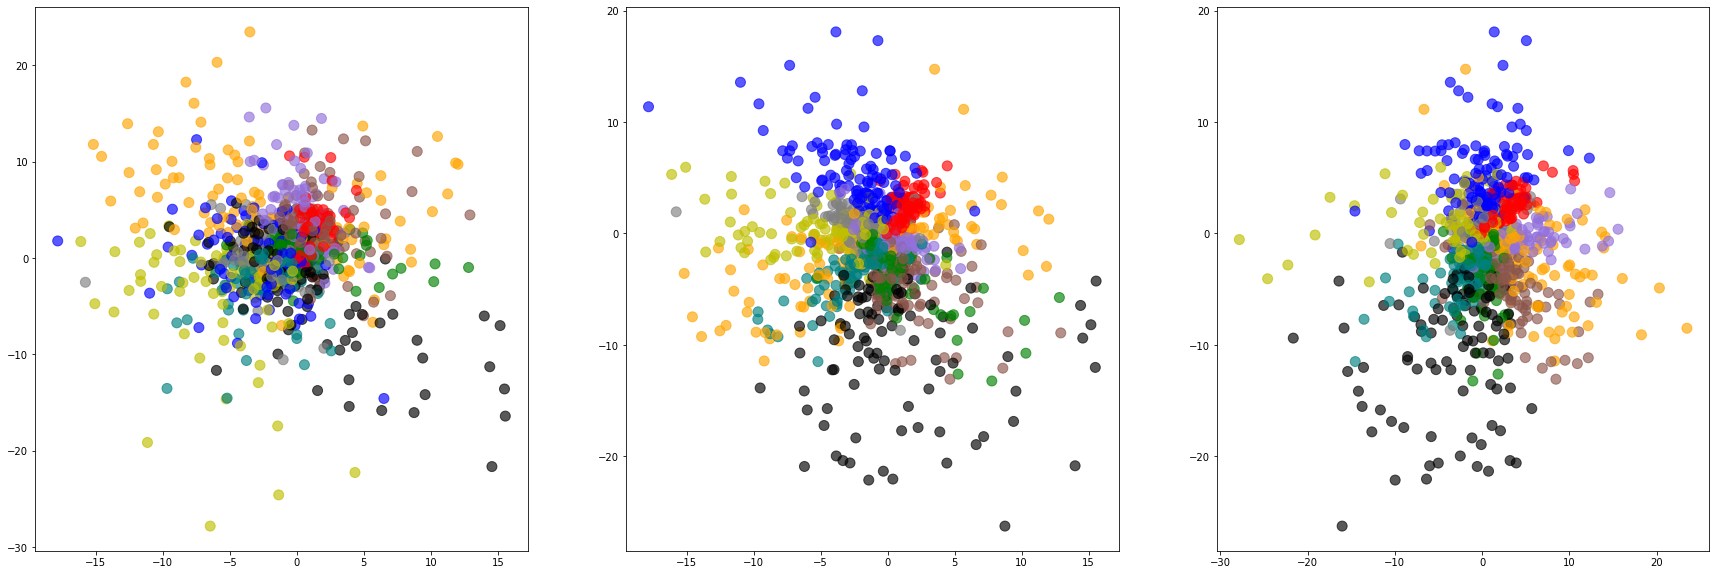

In [12]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3) # This is our 2-dimension plots
fig.set_size_inches(30, 10)
#Using alpha and size to make better visualization
#We can better see the aggregation through this
ax1.scatter(x,y, c = labels, alpha=0.65, s=100)
ax2.scatter(x,z, c = labels, alpha=0.65, s=100)
ax3.scatter(y,z, c = labels, alpha=0.65, s=100)

## 3D Scatter Plot

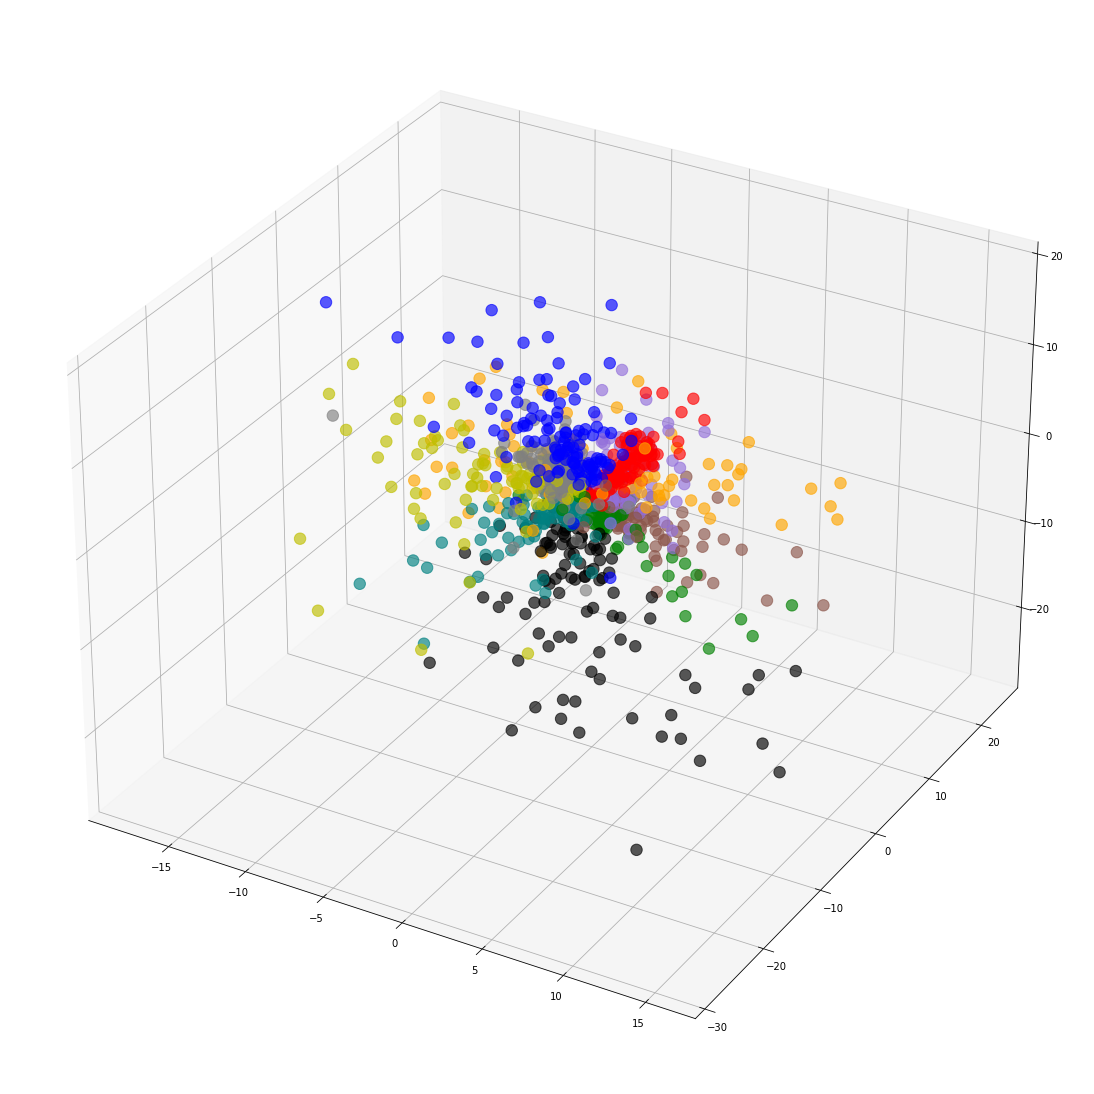

In [13]:
fig = plt.figure()
fig.set_size_inches(15, 15)
#3-dimension graph
ax = Axes3D(fig)
ax.scatter(x,y,z, c = labels, alpha=0.65, s=130)

# D. Plot reconstructed digit images

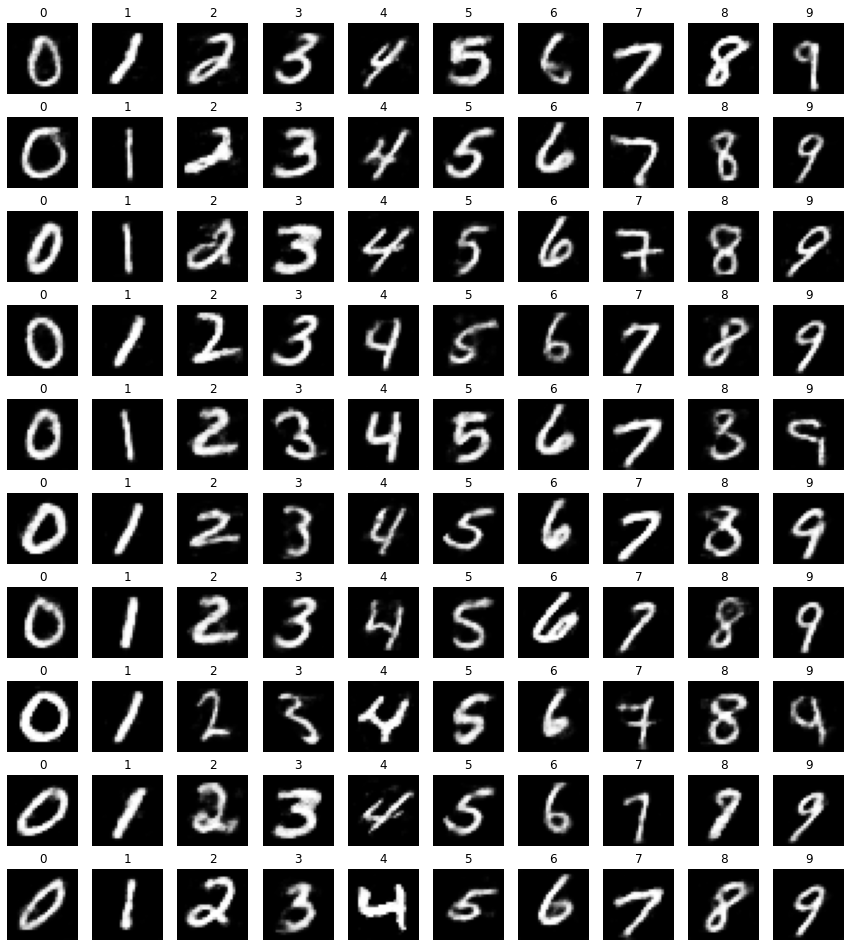

In [14]:
plt.figure(figsize=(15,17))
#For each number like 0, 1, 2... We pick ten random image.
#They are obtained by processing the images of the corresponding number
#If we only pick one, things might not be that obvious since we could get
# a good result by luck. So, we could take ten random for each.
titles = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
for i in range(100):
    plt.subplot(10,10,i+1)
    Draw(data2[random.choice(np.where(number == (i%10))[0])]); plt.title(titles[i%10]);
    
#We can see the results are pretty good, so the probability of getting 
# a correct image is very high

Digit Reconstructions



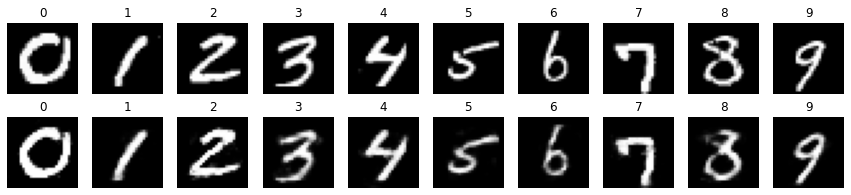

In [15]:
plt.figure(figsize=(15,17))
x,t = next(iter(train_all))
#This is for our assignment questions
#The second row is the result of CNN, first row is the image
titles = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
l = [] #for saving
for i in range(20):
    plt.subplot(10,10,i+1)
    if(i < 10):
        num = random.choice(np.where(number == (i%10))[0])
        l.append(num)
        Draw(x[num]); plt.title(titles[i%10]);
        
    else:
        Draw(data2[l[i%10]]); plt.title(titles[i%10]);